In [3]:
import pickle
from brokenaxes import brokenaxes
import numpy as np
import pandas as pd
import itertools as it
from pathlib import Path
import matplotlib.pylab as plt
from lameg.util import get_files, make_directory, check_many
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from copy import copy

/home/mszul/miniconda3/envs/lameg/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
snr_res = Path("/scratch/coreg_analysis/snr_simulations/")
snr_files = get_files(snr_res, "*.pickle")

In [8]:
def annotate_mx(im, txt_mx, **textkw):
    kw = dict(
        horizontalalignment="center",
        verticalalignment="center"
    )
    kw.update(textkw)
    for r, c in it.product(range(txt_mx.shape[0]), range(txt_mx.shape[1])):
        im.axes.text(r, c, txt_mx[r, c], **kw)

def colorbar(mappable, label):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)
    return cbar


def plot_mx(mx, LAB, title="", ax=False, labels=False, cbar=False, cmap="Spectral_r", norm=False, cbar_label=r"$\Delta$ FE"):
    if not ax:
        f, ax = plt.subplots(1, 1)
    else:
        ax = ax
    if not norm:
        iw = ax.imshow(mx.T, cmap=cmap)
    else:
        iw = ax.imshow(mx.T, cmap=cmap, norm=norm)
    if labels:
        ax.set_ylabel("Evaluation Layer")
        ax.set_xlabel("Simulation Layer")
        ax.set_xticks(np.arange(11).astype(int))
        ax.set_xticklabels(LAB)
        ax.set_yticks(np.arange(11).astype(int))
        ax.set_yticklabels(LAB)
        plt.suptitle(title)
        plt.tight_layout()
    if cbar:
        colorbar(iw, cbar_label)
    return iw


def norm_res(mx):
    norm = np.zeros(mx.shape)
    for l in range(mx.shape[0]):
        normed = mx[l,:] - np.min(mx[l,:])
        norm[l,:] = normed
    return norm


def find_peaks(mx, marker="*", return_annot=True):
    annot = np.zeros(mx.shape).astype(np.object_)
    peaks = []
    for l in range(mx.shape[0]):
        peak = np.argmax(mx[l, :]) # here is the problem (you find peak in evaluated!)
        annot[l, peak] = 1.0
        peaks.append(peak)
    peaks = np.array(peaks)
    annot_bin = np.copy(annot).astype(float)
    annot[annot==0.0] = None
    annot[annot==1.0] = marker
    if return_annot:
        return peaks, annot, annot_bin
    else:
        return peaks

    
def normalize(x):
    maxx, minx = max(x), min(x)
    max_minus_min = maxx - minx
    return np.array([(elt - minx) / max_minus_min for elt in x])


def bootstrap_func(data, n_boot=1000, prop=0.5, func="mean"):
    n_rows = data.shape[0]
    rows = np.arange(n_rows)
    prop_rows = int(n_rows*prop)
    results = []
    for b in range(n_boot):
        boot_rows = np.random.choice(rows, size=prop_rows)
        if func == "mean":
            results.append(data[boot_rows].mean(axis=0))
        elif func == "sem":
            results.append(data[boot_rows].std(axis=0) / np.sqrt(prop_rows))
    return np.array(results)

def bootstrap(data, n_boot=1000, prop=0.5):
    n_rows = data.shape[0]
    rows = np.arange(n_rows)
    prop_rows = int(n_rows*prop)
    results = []
    for b in range(n_boot):
        boot_rows = np.random.choice(rows, size=prop_rows)
        results.append(data[boot_rows])
    return np.array(results)

def shuffled_peak_error(mx, ab=False):
    mx_sh = shuffle_mx(mx)
    peaks = find_peaks(mx_sh, return_annot=False)
    peaks = peaks - np.arange(mx.shape[0])
    if not ab:
        return peaks
    else:
        return np.abs(peaks)


def shuffle_mx(mx):
    mx_shape = mx.shape
    mx = mx.flatten()
    np.random.shuffle(mx)
    return mx.reshape(mx_shape)

In [9]:
fnms = np.array([[i] + i.stem.split("_") for i in snr_files])
map_fnms = np.array([i in [1, 3, 5, 6] for i in range(7)])
fnms = fnms[:,~map_fnms]
names_ = ["filename", "vx", "snr"]
df_files = pd.DataFrame.from_dict(
    {k: fnms[:,i] for i, k in enumerate(names_)}
)
df_files["matrix"] = None
df_files.vx = df_files.vx.apply(lambda x: eval(x))
df_files.snr = df_files.snr.apply(lambda x: eval(x))
mxs = []
for ix, row in df_files.iterrows():
    with open(row.filename, "rb") as file:
        output = pickle.load(file)
    output = output["layerF"]
    df_files.at[ix, "matrix"] = output

In [10]:
vertices = df_files.vx.unique()
vertices.sort()
snrs = df_files.snr.unique()
snrs.sort()

n_layers = 11
layers = np.arange(n_layers).astype(int)
LAB = list(layers)
LAB[0] = "P"
LAB[-1] = "W"

In [12]:
output_sep_vxs = Path("/scratch/coreg_analysis/img_outputs/separate_vxs_snr/")

matrices_all = {i: [] for i in snrs}
peaks_all = {i: [] for i in snrs}
annots_bin = {i: [] for i in snrs}

for vx in vertices:
#     f, ax = plt.subplots(1, snrs.shape[0], figsize=(30, 3))
    for snr_ix, snr in enumerate(snrs):
        row = df_files.loc[
            (df_files.vx == vx) &
            (df_files.snr == snr)
        ]
        mx = row.matrix.values[0]
        mx = norm_res(mx)
        peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
#         iw = plot_mx(
#             mx, LAB, ax=ax[snr_ix], labels=True, cbar=True
#         )
#         annotate_mx(iw, annot)
#         ax[snr_ix].set_title(f"SNR: {snr}, max: {np.round(np.max(mx), 5)}")
        
        matrices_all[snr].append(mx)
        peaks_all[snr].append(peaks)
        annots_bin[snr].append(annot_bin)

#     f.suptitle(f"VX: {vx}")
#     plt.tight_layout()
#     plt.savefig(output_sep_vxs.joinpath(f"snr_vx_{vx}.png"))
#     plt.close()

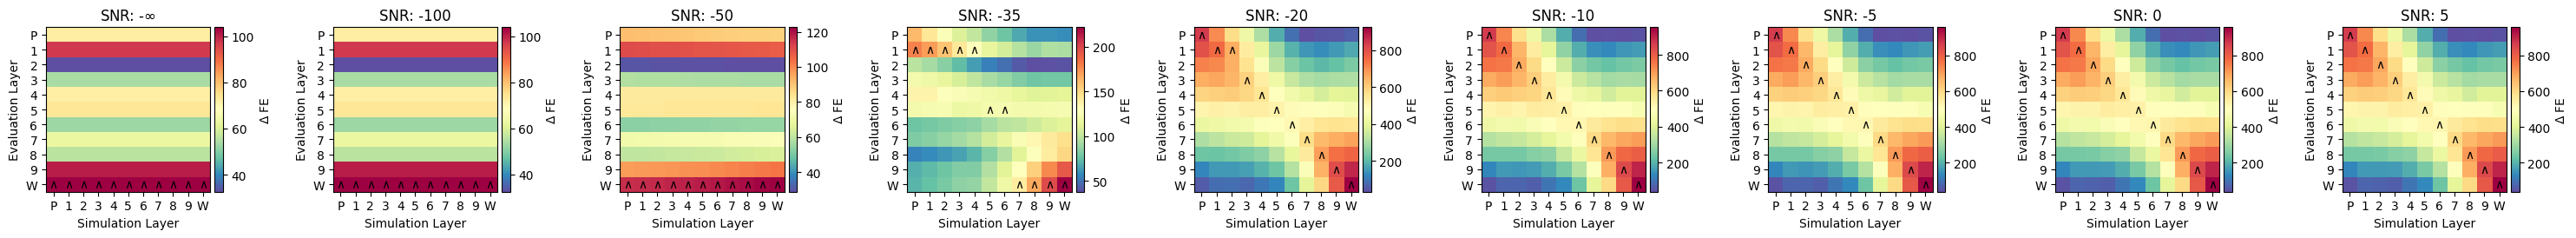

In [58]:
output_sum = Path("/scratch/coreg_analysis/img_outputs/")
f, ax = plt.subplots(1, snrs.shape[0], figsize=(30, 3), facecolor="white")
for snr_ix, snr in enumerate(snrs):
    if snr_ix == 0:
        ax[snr_ix].set_title(r"SNR: -$\infty$")
    else:
        ax[snr_ix].set_title(f"SNR: {snr}")
    m_mx = np.mean(matrices_all[snr], axis=0)
    peaks, annot, annot_bin = find_peaks(m_mx, marker=r"$\wedge$")
    iw = plot_mx(m_mx, LAB, ax=ax[snr_ix], labels=True, cbar=True, cbar_label=r"$\Delta$ FE")
    annotate_mx(iw, annot)
plt.tight_layout()
plt.savefig(output_sum.joinpath(f"snr_mean_FE.svg"))

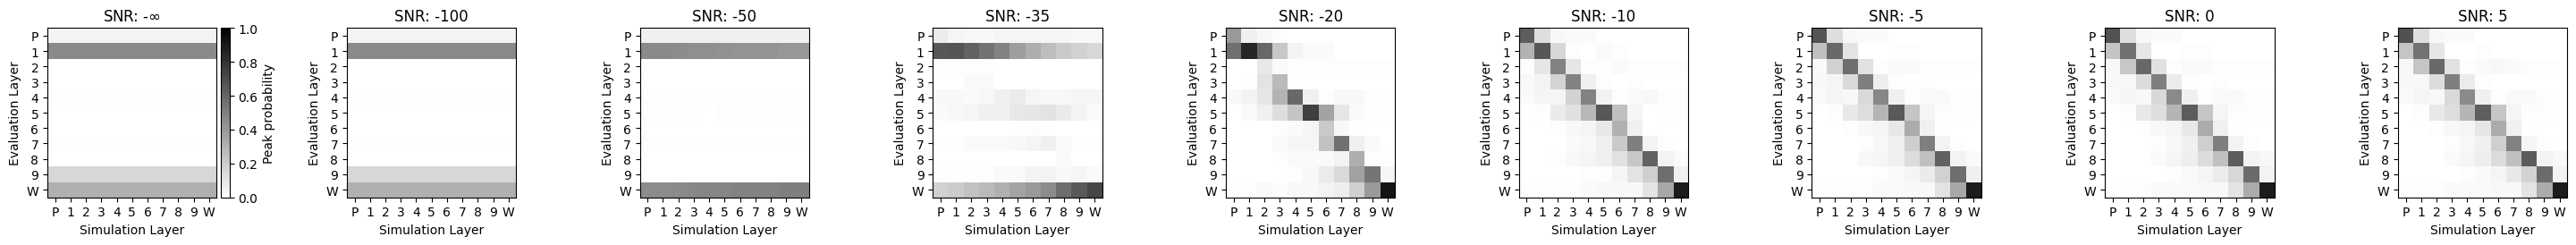

In [59]:
output_sum = Path("/scratch/coreg_analysis/img_outputs/")
divnorm = Normalize(vmin=0, vmax=1)
f, ax = plt.subplots(1, snrs.shape[0], figsize=(30, 3), facecolor="white")
for snr_ix, snr in enumerate(snrs):
    
    m_mx = np.mean(annots_bin[snr], axis=0)
    if snr_ix == 0:
        iw = plot_mx(m_mx, LAB, ax=ax[snr_ix], labels=True, cmap="binary", norm=divnorm, cbar=True, cbar_label=r"Peak probability")
        ax[snr_ix].set_title(r"SNR: -$\infty$")
    else:
        ax[snr_ix].set_title(f"SNR: {snr}")
        iw = plot_mx(m_mx, LAB, ax=ax[snr_ix], labels=True, cmap="binary", norm=divnorm)
plt.tight_layout()
plt.savefig(output_sum.joinpath(f"snr_peak_probablility.svg"))



In [27]:
snr_range = np.arange(len(snrs))
res = []
shuf_res = []
for snr_ix, snr in enumerate(snrs):
    data = layers - np.array(peaks_all[snr])
    data = np.abs(data)
    data = np.mean(data, axis=-1)
    bs = bootstrap(data, n_boot=5000)
    bs_mn = bs.mean(axis=1)
    
    shuf_data = np.array([shuffled_peak_error(i, ab=True) for i in matrices_all[snr]*10])
    shuf_data = np.mean(shuf_data, axis=-1)
    shuf_bs = bootstrap(shuf_data, n_boot=5000)
    shuf_bs_mn = shuf_bs.mean(axis=1)
    
    ci_s = [
        np.percentile(bs_mn, 12.5), 
        np.percentile(bs_mn, 87.5)
    ]
    
    shuf_ci_s = [
        np.percentile(shuf_bs_mn, 12.5), 
        np.percentile(shuf_bs_mn, 87.5)
    ]
    
    p_75 = [
        np.percentile(data, 12.5), 
        np.percentile(data, 87.5)
    ]
    shuf_p_75 = [
        np.percentile(shuf_data, 12.5), 
        np.percentile(shuf_data, 87.5)
    ]
    
    res.append([bs_mn.mean()] + ci_s + p_75)
    shuf_res.append([shuf_bs_mn.mean()] + shuf_ci_s + shuf_p_75)

error_res = np.array(res)
error_shuf_res = np.array(shuf_res)

In [30]:
res = []
shuf_res = []
for snr_ix, snr in enumerate(snrs):
    data = layers - np.array(peaks_all[snr])
#     data = np.abs(data)
    data = np.mean(data, axis=-1)
    bs = bootstrap(data, n_boot=5000)
    bs_mn = bs.mean(axis=1)
    
    shuf_data = np.array([shuffled_peak_error(i, ab=False) for i in matrices_all[snr]*10])
    shuf_data = np.mean(shuf_data, axis=-1)
    shuf_bs = bootstrap(shuf_data, n_boot=5000)
    shuf_bs_mn = shuf_bs.mean(axis=1)
    
    ci_s = [
        np.percentile(bs_mn, 2.5), 
        np.percentile(bs_mn, 97.5)
    ]
    
    shuf_ci_s = [
        np.percentile(shuf_bs_mn, 12.5), 
        np.percentile(shuf_bs_mn, 87.5)
    ]
    
    p_75 = [
        np.percentile(data, 12.5), 
        np.percentile(data, 87.5)
    ]
    shuf_p_75 = [
        np.percentile(shuf_data, 12.5), 
        np.percentile(shuf_data, 87.5)
    ]
    
    res.append([bs_mn.mean()] + ci_s + p_75)
    shuf_res.append([shuf_bs_mn.mean()] + shuf_ci_s + shuf_p_75)

bias_res = np.array(res)
bias_shuf_res = np.array(shuf_res)

In [32]:
error_lines = []
for snr_ix, snr in enumerate(snrs):
    data = layers - np.array(peaks_all[snr])
    data = np.abs(data)
    data = np.mean(data, axis=-1)
    error_lines.append(data)
error_lines = np.array(error_lines)

bias_lines = []
for snr_ix, snr in enumerate(snrs):
    data = layers - np.array(peaks_all[snr])
    data = np.mean(data, axis=-1)
    bias_lines.append(data)
bias_lines = np.array(bias_lines)

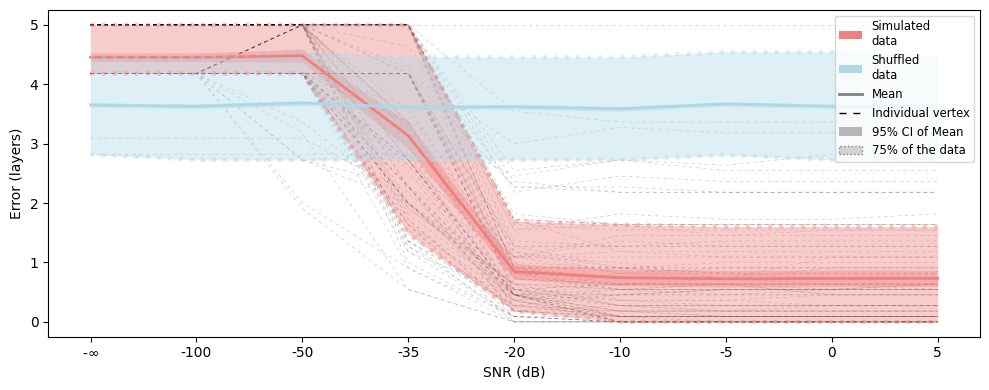

In [56]:
output_sum = Path("/scratch/coreg_analysis/img_outputs/")

legend_handles = [
    Patch(facecolor="lightcoral", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="lightblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
    Patch(facecolor="lightgray", label="75% of the data", linestyle=":", edgecolor="gray"),
]

f, ax = plt.subplots(1, 1, figsize=(10,4), facecolor="white")

clrs = ["lightcoral", "lightblue"]
labs = ["simulated data", "shuffled data"]

for rix, r in enumerate([error_res, error_shuf_res]):
    ax.plot(snr_range, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_range, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
    ax.fill_between(snr_range, r[:,3], r[:,4], color=clrs[rix], lw=0.1, alpha=0.4)
    
    ax.plot(snr_range, r[:,3], ":", lw=3, color=clrs[rix], alpha=0.4)
    ax.plot(snr_range, r[:,4], ":", lw=3, color=clrs[rix], alpha=0.4)
    

ax.set_xticks(snr_range)
tick_labels = [f"{i}" for i in snrs]
tick_labels[0] = r"-$\infty$"
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Error (layers)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="small", loc=1)

ax.plot(snr_range, error_lines, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0)

plt.tight_layout()
plt.savefig(output_sum.joinpath(f"snr_absolute_error.svg"))

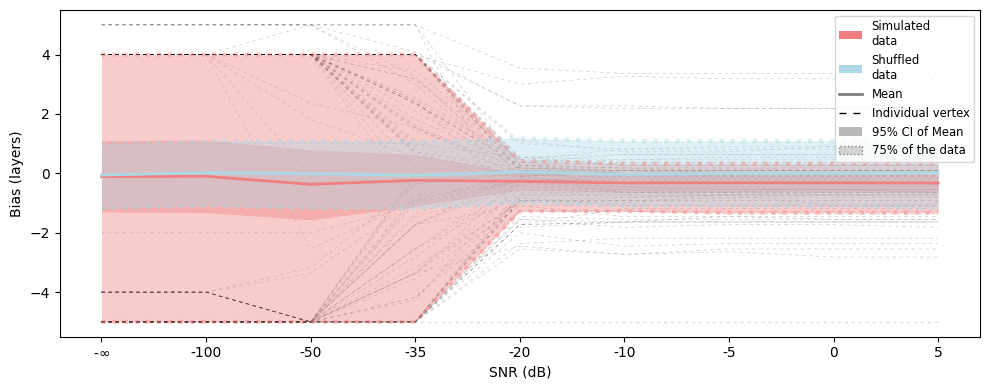

In [57]:
output_sum = Path("/scratch/coreg_analysis/img_outputs/")

legend_handles = [
    Patch(facecolor="lightcoral", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="lightblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
    Patch(facecolor="lightgray", label="75% of the data", linestyle=":", edgecolor="gray"),
]

f, ax = plt.subplots(1, 1, figsize=(10,4), facecolor="white")

clrs = ["lightcoral", "lightblue"]
labs = ["simulated data", "shuffled data"]

for rix, r in enumerate([bias_res, bias_shuf_res]):
    ax.plot(snr_range, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_range, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
    ax.fill_between(snr_range, r[:,3], r[:,4], color=clrs[rix], lw=0.1, alpha=0.4)
    
    ax.plot(snr_range, r[:,3], ":", lw=3, color=clrs[rix], alpha=0.4)
    ax.plot(snr_range, r[:,4], ":", lw=3, color=clrs[rix], alpha=0.4)
    

ax.set_xticks(snr_range)
tick_labels = [f"{i}" for i in snrs]
tick_labels[0] = r"-$\infty$"
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Bias (layers)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="small", loc=1)

ax.plot(snr_range, bias_lines, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0)

plt.tight_layout()
plt.savefig(output_sum.joinpath(f"snr_bias_error.svg"))

In [43]:
snr_range

array([0, 1, 2, 3, 4, 5, 6, 7, 8])